In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
np.set_printoptions(suppress=True)
pd.set_option('display.float_format',lambda x : '%.20f' % x)
pd.set_option('display.max_columns', None)
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, cross_val_score


In [2]:
df = pd.read_csv("../dataset/train.csv")
df_v2 = df[df['windmill_generated_power(kW/h)'].notna()] #移除掉 y 為 na
df_v2 = df_v2.dropna(subset=['cloud_level', 'turbine_status']) #移除類別變數是 na 的
df_v2 = df_v2.drop(columns=['generator_temperature(°C)']) #移除共線性高的其中一個欄位

In [3]:
print(df.shape)
print(df_v2.shape) 

(28200, 22)
(25985, 21)


In [4]:
x = df_v2.iloc[:, 2:-1]
y = df_v2.iloc[:, -1:]

In [5]:
column_name = x.columns.tolist()
column_name

['wind_speed(m/s)',
 'atmospheric_temperature(°C)',
 'shaft_temperature(°C)',
 'blades_angle(°)',
 'gearbox_temperature(°C)',
 'engine_temperature(°C)',
 'motor_torque(N-m)',
 'atmospheric_pressure(Pascal)',
 'area_temperature(°C)',
 'windmill_body_temperature(°C)',
 'wind_direction(°)',
 'resistance(ohm)',
 'rotor_torque(N-m)',
 'turbine_status',
 'cloud_level',
 'blade_length(m)',
 'blade_breadth(m)',
 'windmill_height(m)']

In [6]:
column_name_no_category = column_name.copy()
column_name_no_category.remove('cloud_level')
column_name_no_category.remove('turbine_status')
column_name_no_category

['wind_speed(m/s)',
 'atmospheric_temperature(°C)',
 'shaft_temperature(°C)',
 'blades_angle(°)',
 'gearbox_temperature(°C)',
 'engine_temperature(°C)',
 'motor_torque(N-m)',
 'atmospheric_pressure(Pascal)',
 'area_temperature(°C)',
 'windmill_body_temperature(°C)',
 'wind_direction(°)',
 'resistance(ohm)',
 'rotor_torque(N-m)',
 'blade_length(m)',
 'blade_breadth(m)',
 'windmill_height(m)']

In [7]:
x.isna().sum()

wind_speed(m/s)                   260
atmospheric_temperature(°C)      3167
shaft_temperature(°C)               2
blades_angle(°)                   198
gearbox_temperature(°C)             1
engine_temperature(°C)             11
motor_torque(N-m)                  23
atmospheric_pressure(Pascal)     2508
area_temperature(°C)                0
windmill_body_temperature(°C)    2178
wind_direction(°)                4690
resistance(ohm)                     1
rotor_torque(N-m)                 521
turbine_status                      0
cloud_level                         0
blade_length(m)                  4669
blade_breadth(m)                    0
windmill_height(m)                507
dtype: int64

# 前處理

## 移除異常值

1. wind_speed(m/s) 取絕對值

In [8]:
x['wind_speed(m/s)'] = abs(x['wind_speed(m/s)'])

2. atmosphic temp: -99做處理

In [9]:
x[x['atmospheric_temperature(°C)'] == -99]

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m)
0,94.82002337205149444799,-99.00000000000000000000,41.72301901002243340599,-0.90342290299641159201,82.41057318863289538058,42.52301541748178692615,2563.12452227166704687988,103402.96187187572650145739,26.89787489401040687653,NaN,239.83638750521930660398,2730.31060463211269961903,42.08466579565806853225,BA,Medium,2.21754164269036069257,0.31406483544967150889,24.28168893617015200448
6,16.02624902966193332077,-99.00000000000000000000,44.07281919981681994614,-0.19684483420273810039,41.68058346263620705940,43.38490372782855075684,778.10998503055702713027,121813.38315827345650177449,33.84938885636380234700,43.00874573677933199178,528.00398514600408361730,1222.93127026255888267769,11.80511257767306432243,BD,Low,2.91792156604781816043,0.44734137730157030877,33.59351134584613873812
8,47.08172860513744240052,-99.00000000000000000000,-33.60704817840622382619,-99.00000000000000000000,43.05542663523044666363,45.25362821668157664590,957.58015055895975820022,119628.96470912176300771534,26.16807294593738930644,43.21606194160904834689,281.36862519157511997037,-99.00000000000000000000,19.48676278616753876349,ABC,Low,1.65143770105206089127,0.30154962261572021420,46.73350894418016565623
22,47.11468604626261225121,-99.00000000000000000000,43.16964204726475173857,8.11667670356404791221,48.08296413969122795606,47.91271729109672605773,953.49615054570642769249,139445.40573036996647715569,37.87998151745210861918,NaN,494.36816834136197940097,1473.49909896895633210079,17.44740206146922645303,AB,Low,2.46126159455193249670,0.35938038714822900799,27.74716406116337097387
31,96.51544779731844414528,-99.00000000000000000000,46.04952586864884267470,-99.00000000000000000000,47.57186096671368602529,44.86430834437781101087,2785.87482541140707326122,17639.46234350056329276413,43.68499629617180346486,46.16699257705028713872,504.92489398396679689540,1981.23224707114491138782,43.05151825651900310277,A,Medium,4.86095142888405096215,0.34934659208998330993,26.02881949589380283783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28169,156.31049654182848485107,-99.00000000000000000000,42.85349221395164676096,-1.26640709274813367813,41.45669058116275351722,41.21382916637806204108,774.42343227398100680148,121663.18722728510329034179,22.34720067972514101484,41.40349036619588218855,285.06814271269490745908,1242.69052831143721959961,13.56098040421387551646,BCB,Low,2.18486141747571993577,0.34391365420076430715,27.66369615911731827396
28172,12.25749732096434208017,-99.00000000000000000000,44.23490416781482537090,0.84993772250638766064,-29.20310005495257854591,42.07064436714432531517,782.33768880576371884672,NaN,28.10128546114932035493,42.38419486057836138571,306.10479926641949077748,1193.57430652022662798117,12.01704823296086388495,BBB,Low,3.22819633194971578050,0.33375046942189390276,44.25797941042824135138
28175,95.48068884298515968112,-99.00000000000000000000,42.84407132934770601196,-1.18460126550866506889,45.72992865671341888856,45.20247971805036257820,2325.04908249243590034894,NaN,28.16635176230962400723,-99.00000000000000000000,234.25433009035137388310,1782.52270248006448127853,38.60273314385990062192,BBB,Medium,NaN,0.42953690591090837314,23.03978958300769619427
28177,238.19722733816888649017,-99.00000000000000000000,43.66974293559891862060,-99.00000000000000000000,42.23260979258833458516,42.91162204689239700883,2130.21266138859209604561,468449.36140980559866875410,28.96914794249380520341,43.59164691352150811099,0.00000000000000000000,468.33234367596969605074,35.07569936414581235340,D,Medium,3.74342528331804080821,0.49715108488637638207,26.73022840296817648209


In [10]:
x['atmospheric_temperature(°C)'] = x.apply(lambda r:np.NaN if r['atmospheric_temperature(°C)'] == -99 else r['atmospheric_temperature(°C)'] , axis=1)

In [11]:
x[x['atmospheric_temperature(°C)'] == -99]

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m)


3. windmill body 處理：-999

In [12]:
x[x['windmill_body_temperature(°C)'] == -999]

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m)
10999,23.51058716325440656192,NaN,44.08699886558024161332,-99.00000000000000000000,44.98196928085020829258,43.53695151711760047419,823.48607907839436848008,116900.54973733224323950708,28.68713652734886920825,-999.00000000000000000000,NaN,1266.35385879522800678387,13.04089464391271668831,D,Medium,4.31763012503587706448,0.47324202115881697228,25.29614602462113026604
15782,94.57472829951456105846,21.07133479148264143532,79.46828311309403147789,7.14286906604190718895,46.58050309507237329854,44.15766509357395364077,2920.01032729310418289970,19317.16114757845571148209,38.21209086054588510706,-999.00000000000000000000,375.77277074181199623126,1976.98504351436076831305,45.95299004607852566551,D,Medium,NaN,0.40855780960606141727,25.04943859998407873491
17944,93.78939020632472534089,NaN,18.73470473110980094589,-0.11369900558463119644,42.50076236205482871355,43.14280830028569369006,2042.95871040126803563908,-277706.96375938528217375278,30.48992565429453094339,-999.00000000000000000000,208.90367218227927992302,465.24315682486258083372,35.26483168055886352477,B2,Low,2.39746322880956697077,0.49570986541854139551,24.54303974915751140884


In [13]:
x['windmill_body_temperature(°C)'] = x.apply(lambda r:np.NaN if r['windmill_body_temperature(°C)'] == -999 else r['windmill_body_temperature(°C)'] , axis=1)

In [14]:
x[x['windmill_body_temperature(°C)'] == -999]

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m)


4. blade_length: -99 處理

In [15]:
x[x['blade_length(m)'] == -99]

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m)
120,47.27059640270789486749,NaN,45.03125428837431343254,2.51317845604695300210,44.43278214356632105364,48.77152749087370864345,985.13530320809604745591,133897.78387885159463621676,42.90280355494631692181,42.62631615249067351670,NaN,1472.94355496447610676114,17.14778310128342297958,BBB,Medium,-99.00000000000000000000,0.48386585833996131889,35.63187379613538041667
263,59.50216912020798076810,NaN,44.21915077678759331548,9.93016483368430868950,44.29026593391262167643,48.42462650868027651541,2955.36446536164521603496,-399416.76373797788983210921,47.26429222942059027446,45.74954329788503315513,NaN,1987.78139409926643565996,43.58941405878385921824,B,Medium,-99.00000000000000000000,0.48740417659294538177,26.08325491825782904698
431,44.05944503106478293830,NaN,46.59845956593719051853,4.35539163067501622351,70.90270529193362847309,46.93906463046884169898,944.74870955334802147263,135207.38618489183136262000,42.11016176745024353067,44.09928727489403144091,NaN,1436.93672583155171196267,19.03276707040548387795,A2,Low,-99.00000000000000000000,0.47198838299219719739,25.79400830590362048156
461,93.57688285855213905506,NaN,45.14029157659084035004,-99.00000000000000000000,45.53093337358652803459,48.68976059911473441844,2666.48477273376010998618,18137.06351658605854026973,40.38853753433780724436,42.93457114440735011840,NaN,1897.14202070023770829721,41.94826533004535207283,BBB,Low,-99.00000000000000000000,0.41380001954264700181,27.63270633748566140753
603,10.10142072704621263313,8.48219997475208487003,42.83045720185076277176,37.72433490681564904889,96.15596622915512625696,40.82548507875750942731,520.28086085343431932415,304471.61271332809701561928,31.77710434425518570833,-99.00000000000000000000,293.83000707624296410359,1163.95383431496111370507,5.52923273358472133765,B,Medium,-99.00000000000000000000,0.41128609775350738476,24.06334818594902458244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27750,95.12652525389086122232,29.84274856298546296784,47.61858063076317648665,3.34884618725288607521,47.09205656996734035147,44.98550642290199164108,2811.31799464404321042821,NaN,44.50485857369147879581,44.63917777927994734455,253.42927953783220118567,1678.88709983084913801576,46.77903179318717263868,AAA,Low,-99.00000000000000000000,0.30086256855250159692,41.96879971335526704479
27812,95.56944954248143631048,21.47359103708265593013,15.03095235260319917359,5.01037531525087764805,-104.76142385824023506302,44.74238166862728149908,2736.53877078454070215230,NaN,41.51854409064020501319,45.12639449672960267890,508.86524965503218709273,1943.83875957452482907684,-99.00000000000000000000,BBB,Low,-99.00000000000000000000,0.45118338602343910360,31.98782360822298542757
27951,14.54464433241909127048,14.14214680965969250792,41.57961471403221054288,-0.23702235275516531088,41.46864815676160276325,44.22192585321659663578,776.29326479405585814675,111619.59280525587382726371,28.08607709258468787539,41.96252491085965630191,NaN,1215.10946477558650258288,12.65302545186001381694,A,Medium,-99.00000000000000000000,0.34961380456087470803,2.60017206335162098796
28001,91.60834122857701800058,22.61729259092461319369,43.59589953830735709062,0.19839531843204760708,42.45900021050904626918,41.84246034807053149507,2108.72120637365105721983,17042.54458273192722117528,23.12792864241016133064,5.25561991680503837188,246.45436748316743091891,1707.73879055276688632148,37.20935590596445763367,BCB,Medium,-99.00000000000000000000,0.46343788196999241569,25.05110706281001142770


In [16]:
x['blade_length(m)'] = x.apply(lambda r:np.NaN if r['blade_length(m)'] == -99 else r['blade_length(m)'] , axis=1)

In [17]:
x[x['blade_length(m)'] == -99]

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m)


5. wind_direction(°) > 360 者 -360

In [18]:
x[x['wind_direction(°)'] >360]

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m)
6,16.02624902966193332077,NaN,44.07281919981681994614,-0.19684483420273810039,41.68058346263620705940,43.38490372782855075684,778.10998503055702713027,121813.38315827345650177449,33.84938885636380234700,43.00874573677933199178,528.00398514600408361730,1222.93127026255888267769,11.80511257767306432243,BD,Low,2.91792156604781816043,0.44734137730157030877,33.59351134584613873812
17,95.30274133172653705515,26.33603497015068484188,13.39490541923125022095,8.33555811130547574805,45.36362965181719175689,44.08143605157796685035,2967.57010084044077302678,19066.13646639380021952093,36.02007390806238618097,-99.00000000000000000000,475.32715314375207071862,1955.48291788046890360420,49.57836097950765719133,BCB,Medium,2.93484919082212503127,0.37816709460177860835,25.27841610607175937275
20,213.15445133025821178308,35.61207693738330704036,42.71052259813699691904,-0.83640492510277342220,34.21133956505246942470,41.54210864560364768749,2388.03376147058497735998,17184.07374039521891972981,41.97568662992414090240,43.66619519547344907551,488.33312560704320048899,1797.62395475724429161346,-13.15007061512579156215,ABC,Medium,NaN,0.44429974167125790840,27.32419707315796486569
22,47.11468604626261225121,NaN,43.16964204726475173857,8.11667670356404791221,48.08296413969122795606,47.91271729109672605773,953.49615054570642769249,139445.40573036996647715569,37.87998151745210861918,NaN,494.36816834136197940097,1473.49909896895633210079,17.44740206146922645303,AB,Low,2.46126159455193249670,0.35938038714822900799,27.74716406116337097387
27,94.66039549697450183885,28.51421112555181025527,42.76700334041760243053,-99.00000000000000000000,42.07166073046629151122,42.60624546309033888747,2138.32962588675991355558,17132.32058122586386161856,24.28370284317124827567,-5.58889825695040798337,501.61875176990014324474,1724.87368294503880861157,-38.30394933370973831188,A2,Medium,3.51090463598035018578,0.48748694649871521234,24.85940585465817065369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28171,39.22150587623158912720,29.45127340481712963083,79.07990886709933420207,0.25875093638638257953,45.71350556870691406175,46.74643537791816072513,2846.09254162408069532830,-150331.67278018768411129713,40.62998146264601473376,44.46309668241286061630,541.13566226299667505373,1965.95925525550001111696,42.64927489071552457744,AC,Medium,3.00896748447784112557,0.33739222496918241934,27.91534432982828306535
28191,96.29792049536672493559,NaN,48.09727779859696283893,7.67618869501098011199,46.83799357859206935473,45.21506414220289116201,2800.77638458558385536890,19156.69304913992527872324,41.47053751657492171034,-99.00000000000000000000,513.10877983437637794850,893.85171274978824840218,47.95907033569672250906,B2,Medium,NaN,0.31515138711432760799,2.34953181867243188208
28195,94.76569864457700020921,23.57679326496327831819,45.39935215858018580093,5.37722197443881544388,-1.08517081195051900977,48.52824759898769713118,2791.60098987063020103960,19428.72507915375172160566,45.42922989159210089838,44.24226850903467322951,536.15341310738676838810,1980.86192089038240737864,45.90905417035089897126,BB,Medium,2.77433536802225289009,0.41829944263358148637,24.59080102954732538478
28197,94.16046346505811470706,28.67429569500961150652,45.00421329298214345727,9.55035783290001205614,49.37770574900832087906,44.04263227801639857262,2801.65737397266002517426,19083.88144874662248184904,45.12944228215584274722,43.57650981156393044103,534.20991255932858621236,1951.72871279418109224935,88.31915198695602953194,D,Medium,NaN,0.38026433977011980803,28.53384965809278384086


In [19]:
x.loc[x['wind_direction(°)'] > 360, 'wind_direction(°)'] -= 360

In [20]:
x[x['wind_direction(°)'] >360]

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m)


In [21]:
x.shape

(25985, 18)

## 補值

## MICE

In [22]:
nocate_x = x.drop(['cloud_level', 'turbine_status'], axis=1)

In [23]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp_mean = IterativeImputer(random_state=0)
new_x_no_category = imp_mean.fit_transform(nocate_x)


In [24]:
df_mice = pd.DataFrame(data=new_x_no_category, columns=column_name_no_category)
df_mice['cloud_level'] = x['cloud_level']
df_mice['turbine_status'] = x['turbine_status']
df_mice

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),blade_length(m),blade_breadth(m),windmill_height(m),cloud_level,turbine_status
0,94.82002337205149444799,22.02824539985887142279,41.72301901002243340599,-0.90342290299641159201,82.41057318863289538058,42.52301541748178692615,2563.12452227166704687988,103402.96187187572650145739,26.89787489401040687653,20.53948164113333518799,239.83638750521930660398,2730.31060463211269961903,42.08466579565806853225,2.21754164269036069257,0.31406483544967150889,24.28168893617015200448,Medium,BA
1,241.83273424332921308633,27.76478479112672914653,-99.00000000000000000000,-99.00000000000000000000,44.10491890863708874804,46.25887000379637470360,2372.38411894775981636485,17030.90407797775333165191,39.80146882708524458394,28.28827326866714031439,337.94472273324237221459,1780.20719959988082337077,107.88864300855439637417,4.21034630125676301304,0.44849442281167078983,27.26213869532712763544,Medium,A2
2,95.48472431680220040562,20.42163895260478412297,41.85547318972749053501,12.65276347555559155467,42.32209842785778164398,42.87855166354412261853,1657.16964619576901895925,16125.92710723713571496774,36.11606465409759891827,45.03319674848240339315,227.85029392100651080000,1666.04989997854249850207,-42.93145891998506158416,2.71947497531688497929,0.30232099622293528984,27.36612717682671913622,Medium,ABC
3,10.72289003453362354890,13.07354950901029333465,41.98118341361987404525,1.71569609953903001731,-17.61645850056690676411,43.46985211107323721080,781.69541918080744835606,114468.16900708740286063403,34.57294057613650295480,-99.00000000000000000000,259.27460055704921160213,1177.51615219866152983741,13.38728879162814244808,3.41159080268792624935,0.45337371770023310313,27.97165033838181003034,NaN,NaN
4,93.76997287836076111489,30.32622646751744355242,17.97061855759169546332,-99.00000000000000000000,43.81643007916191834283,40.81579477920148946168,2119.35165325592970475554,15192.42504589457530528307,35.31529232869900170044,101.37818430578464301561,190.59400561476442703679,1715.24412097675417498976,97.74646258321948266712,2.50409796739862722248,0.39564195100014931672,24.67329155420776487517,Medium,AAA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25980,94.76569864457700020921,23.57679326496327831819,45.39935215858018580093,5.37722197443881544388,-1.08517081195051900977,48.52824759898769713118,2791.60098987063020103960,19428.72507915375172160566,45.42922989159210089838,44.24226850903467322951,176.15341310738676838810,1980.86192089038240737864,45.90905417035089897126,2.77433536802225289009,0.41829944263358148637,24.59080102954732538478,Medium,A
25981,94.19673791579424459997,24.03432927129641072383,42.06897905171358331700,-99.00000000000000000000,44.28515332521052272341,43.48793865221973220514,2207.88227571371771773556,16596.48540001898800255731,25.14268074240487038651,43.61641170737367190213,354.23982480481606671674,1712.84045665215239750978,36.97491320175291917849,-3.25098855370361183859,0.46153120593574781250,26.05160381668232005836,Medium,AB
25982,94.16046346505811470706,28.67429569500961150652,45.00421329298214345727,9.55035783290001205614,49.37770574900832087906,44.04263227801639857262,2801.65737397266002517426,19083.88144874662248184904,45.12944228215584274722,43.57650981156393044103,174.20991255932858621236,1951.72871279418109224935,88.31915198695602953194,3.49050371301634188015,0.38026433977011980803,28.53384965809278384086,Medium,A2
25983,95.43037721392667549480,26.56025356261974934569,48.03262437894481706735,3.05138937540971699747,81.44389642162765596822,44.82136498526500645312,2760.64727953425244777463,18360.78570664651851984672,45.60392722546596644406,44.97341493531936151840,208.50489789264349838049,1968.91769154092526150635,47.56262733354140692654,3.00

In [25]:
df_mice_dummy = pd.get_dummies(df_mice, drop_first=True)


In [26]:
df_mice_dummy.describe()

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),blade_length(m),blade_breadth(m),windmill_height(m),cloud_level_Low,cloud_level_Medium,turbine_status_A2,turbine_status_AAA,turbine_status_AB,turbine_status_ABC,turbine_status_AC,turbine_status_B,turbine_status_B2,turbine_status_BA,turbine_status_BB,turbine_status_BBB,turbine_status_BCB,turbine_status_BD,turbine_status_D
count,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000,25985.00000000000000000000
mean,83.78009471754647563557,19.26410681802014934760,40.05980486862691947181,-9.74068451882216557181,41.01260600138183320951,42.62214671350074723932,1711.51003696919292451639,52561.88591774011729285121,32.74702067099669022809,20.98283898760196919397,206.05794305556781864652,1575.81565497748056259297,25.89518030600245879214,3.47265581950295798563,0.39705734391086677793,25.89643852572903526266,0.46003463536655764266,0.45133730998653071032,0.06499903790648450808,0.06761593226861650763,0.06534539157206080418,0.06392149316913603441,0.06457571675966904123,0.06634596882817009322,0.06646142005002886322,0.06469116798152781123,0.06723109486242062616,0.06407542813161438977,0.06800076967481238910,0.06372907446603809367,0.06726957860304021153
std,59.14414740594574482202,9.40133927072592889829,27.25851823025791276223,47.85160217464871124093,43.73481451089970306612,6.10717879259756735166,827.71544415701964680920,178415.97940530325286090374,7.71636315268523187427,50.92134691125032475156,76.53015175633315436698,485.09996622303464164361,32.13466406117286311428,1.73282243259340584807,0.06123004550590741696,7.70071591821956591417,0.49840980073165674913,0.49763588372509637292,0.24652890679360547899,0.25109051004581856015,0.24713907394736467360,0.24461773988005552916,0.24578042698952110023,0.24889066913801408121,0.24909172504037527252,0.24598485596075311821,0.25042661239499669490,0.24489196718383021700,0.25175206863787036315,0.24427438641334039970,0.25049310794725482276
min,1.76824789401925408505,-53.79581308247585269555,-99.00000000000000000000,-146.25954269548714137272,-244.97409783490329004962,3.16715102086201305553,-1483.84420766521816403838,-1188624.13141243648715317249,-30.00000000000000000000,-100.26887558017655521780,0.00000000000000000000,-1005.22298826016674411221,-136.73221690705602782145,-8.25347780130368846585,0.20011099649635460951,-30.29525292058041685550,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000
25%,35.01118955311655867035,12.96088353162985917777,41.63888660052921864008,-1.20619960964944872295,40.55828681164599913700,41.91249818901294332818,870.90845070384170867328,16789.44327514423639513552,27.32284561925085597522,21.67150594912104111245,163.75517350412269479421,1268.37599647721731344063,13.71850334568138229940,2.781

In [27]:
df_mice_dummy.isna().sum()

wind_speed(m/s)                  0
atmospheric_temperature(°C)      0
shaft_temperature(°C)            0
blades_angle(°)                  0
gearbox_temperature(°C)          0
engine_temperature(°C)           0
motor_torque(N-m)                0
atmospheric_pressure(Pascal)     0
area_temperature(°C)             0
windmill_body_temperature(°C)    0
wind_direction(°)                0
resistance(ohm)                  0
rotor_torque(N-m)                0
blade_length(m)                  0
blade_breadth(m)                 0
windmill_height(m)               0
cloud_level_Low                  0
cloud_level_Medium               0
turbine_status_A2                0
turbine_status_AAA               0
turbine_status_AB                0
turbine_status_ABC               0
turbine_status_AC                0
turbine_status_B                 0
turbine_status_B2                0
turbine_status_BA                0
turbine_status_BB                0
turbine_status_BBB               0
turbine_status_BCB  

In [28]:
df_mice_dummy.shape

(25985, 31)

# Model

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df_mice_dummy, y, test_size=0.2, random_state=800)

In [30]:
numCols = [col for col in x.columns if x[col].dtype == 'float64']
xscaler = preprocessing.StandardScaler().fit(X_train[numCols])
#standardize feature values
X_train[numCols] = xscaler.transform(X_train[numCols])
X_test[numCols] = xscaler.transform(X_test[numCols])

In [31]:
total_label = list(df_mice_dummy.columns.values)


In [32]:
import statsmodels.api as sm

X_train_df = pd.DataFrame(data=X_train, columns=total_label)

x_model = sm.add_constant(X_train_df)

est = sm.OLS(np.array(y_train), x_model)
model = est.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     447.8
Date:                Thu, 21 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:41:45   Log-Likelihood:                -44983.
No. Observations:               20788   AIC:                         9.003e+04
Df Residuals:                   20756   BIC:                         9.028e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [33]:
def test_result(model_name, target ,pred):
    target = np.array(target)
    pred = np.array(pred)

    print(f"------ model: {model_name} --------")
    print("mse: ", mean_squared_error(target, pred))
    print("mae: ", mean_absolute_error(target, pred))
    print("rmse: ", mean_squared_error(target, pred, squared=False))
    print("MAPE: ", mean_absolute_percentage_error(target, pred))


In [34]:
import numpy as np
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
score = reg.score(X_test, y_test)

print("score: ", score)

test_result("LinearRegression", y_test, y_pred)

coef = reg.coef_
linear_coef = pd.DataFrame(data=coef[0] , index=X_train.columns.tolist(), columns=['coef'])
linear_coef['abs_coef'] = abs(linear_coef['coef'])
linear_coef.sort_values(by=['abs_coef'], ascending=False)

score:  0.39588841706289846
------ model: LinearRegression --------
mse:  4.173290104154308
mae:  1.5983494394662723
rmse:  2.0428632122964836
MAPE:  0.3312572051378953


,coef,abs_coef
motor_torque(N-m),1.61263442406159174247,1.61263442406159174247
atmospheric_temperature(°C),-0.96563459691898168025,0.96563459691898168025
area_temperature(°C),0.63403665331616765322,0.63403665331616765322
engine_temperature(°C),0.31320682948699907211,0.31320682948699907211
wind_speed(m/s),-0.28328114710916962871,0.28328114710916962871
atmospheric_pressure(Pascal),0.17628271520712721077,0.17628271520712721077
wind_direction(°),-0.13073350662867211369,0.13073350662867211369
blade_breadth(m),0.12636604918191629565,0.12636604918191629565
turbine_status_BBB,-0.10487480456812230123,0.10487480456812230123
blades_angle(°),-0.10159148467802808780,0.10159148467802808780


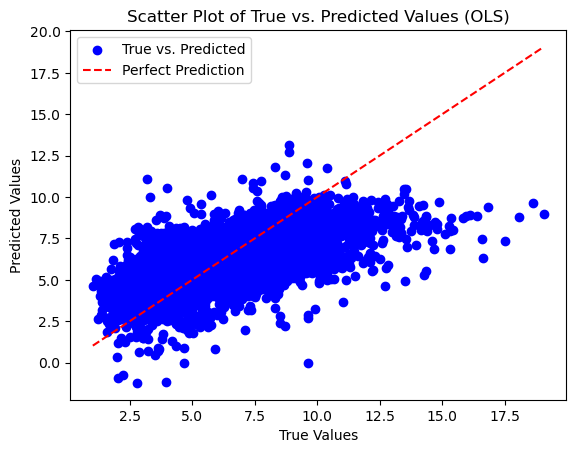

In [35]:
# 繪製散點圖
plt.scatter(y_test, y_pred, color='blue', label='True vs. Predicted')
plt.plot([min(np.array(y_test)), max(np.array(y_test))], [min(np.array(y_test)), max(np.array(y_test))], linestyle='--', color='red', label='Perfect Prediction')

# 加上標題和軸標籤
plt.title('Scatter Plot of True vs. Predicted Values (OLS)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# 加上圖例
plt.legend()

# 顯示圖形
plt.show()

In [36]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=0)

param_grid = {
    'max_depth': [None, 5, 15, 20],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 4]
}


# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(rf, param_grid, cv=10, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_accuracy = grid_search.best_score_
best_params = grid_search.best_params_

# Evaluate the model with the best hyperparameters on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
score = best_model.score(X_test, y_test)

print("score: ", score)
test_result("Random Forest", y_test, y_pred)


feature_importance = np.array(best_model.feature_importances_)
rf_coef = pd.DataFrame(data=feature_importance , index=X_train.columns.tolist(), columns=['feature_importance'])
rf_coef.sort_values(by=['feature_importance'], ascending=False)

/Users/jim/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jim/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jim/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jim/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/model_selection

score:  0.961276913650643
------ model: Random Forest --------
mse:  0.26750467567331837
mae:  0.3019567797681655
rmse:  0.5172085417636858
MAPE:  0.056377062872250236


,feature_importance
motor_torque(N-m),0.60675526180145789024
blades_angle(°),0.20906447649742357364
atmospheric_pressure(Pascal),0.08271882412677868113
resistance(ohm),0.05073623373084987231
engine_temperature(°C),0.01359537938579492324
wind_speed(m/s),0.00855324934177072345
blade_breadth(m),0.00681520889450724920
area_temperature(°C),0.00388851474928206698
gearbox_temperature(°C),0.00331693078763110015
atmospheric_temperature(°C),0.00260620285917847723


In [37]:
print(best_params)

{'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2}


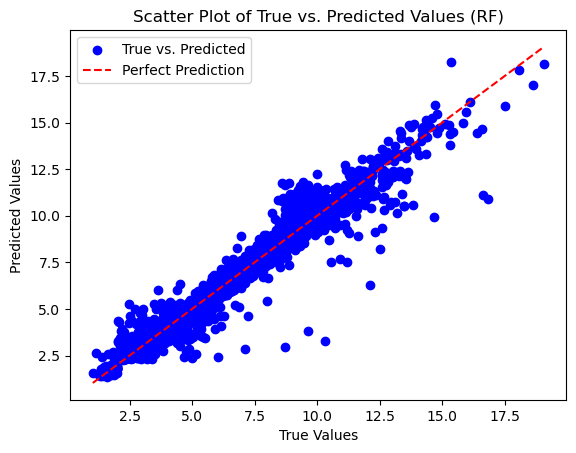

In [38]:
# 繪製散點圖
plt.scatter(y_test, y_pred, color='blue', label='True vs. Predicted')
plt.plot([min(np.array(y_test)), max(np.array(y_test))], [min(np.array(y_test)), max(np.array(y_test))], linestyle='--', color='red', label='Perfect Prediction')

# 加上標題和軸標籤
plt.title('Scatter Plot of True vs. Predicted Values (RF)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# 加上圖例
plt.legend()

# 顯示圖形
plt.show()

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(random_state=0)

param_grid = {
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 4],
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(gb, param_grid, cv=10, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_accuracy = grid_search.best_score_
best_params = grid_search.best_params_

# Evaluate the model with the best hyperparameters on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
score = best_model.score(X_test, y_test)

print("score: ", score)
test_result("GradientBoostingRegressor", y_test, y_pred)
print(best_params)

feature_importance = np.array(best_model.feature_importances_)
rank_of_coef = pd.DataFrame({'coef_name': X_train.columns.tolist(), 'feature_importance': feature_importance })
rank_of_coef.sort_values(by=['feature_importance'], ascending=False)


/Users/jim/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

score:  0.9478409678385674
------ model: GradientBoostingRegressor --------
mse:  0.36032213072835034
mae:  0.3958224260088276
rmse:  0.6002683822494321
MAPE:  0.07799246066982563
{'min_samples_leaf': 4, 'min_samples_split': 2}


,coef_name,feature_importance
6,motor_torque(N-m),0.73037025639873143223
3,blades_angle(°),0.15283720459854463480
11,resistance(ohm),0.04619806512421845840
5,engine_temperature(°C),0.02162882169671118820
7,atmospheric_pressure(Pascal),0.02044374572137930279
0,wind_speed(m/s),0.01733928633427957514
14,blade_breadth(m),0.00597049234907517413
4,gearbox_temperature(°C),0.00310070401975855517
8,area_temperature(°C),0.00087212403867843096
10,wind_direction(°),0.00069365490430065837


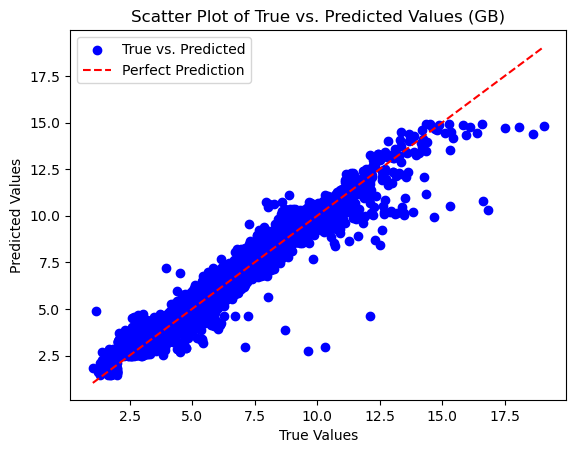

In [40]:
# 繪製散點圖
plt.scatter(y_test, y_pred, color='blue', label='True vs. Predicted')
plt.plot([min(np.array(y_test)), max(np.array(y_test))], [min(np.array(y_test)), max(np.array(y_test))], linestyle='--', color='red', label='Perfect Prediction')

# 
# 加上標題和軸標籤
plt.title('Scatter Plot of True vs. Predicted Values (GB)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# 加上圖例
plt.legend()

# 顯示圖形
plt.show()

In [41]:
from sklearn.linear_model import RidgeCV
import numpy as np

ridge = RidgeCV(alphas = (0.1, 1.0, 5.0, 10.0), cv=10).fit(X_train, y_train)
y_pred = ridge.predict(X_test)
score = ridge.score(X_test, y_test)

print("score: ", score)
test_result("Ridge Regression", y_test, y_pred)
print("alpha", ridge.alpha_)

ridge_coef = pd.DataFrame(data=ridge.coef_[0] , index=total_label, columns=['coef'])
ridge_coef['abs_coef'] = abs(ridge_coef['coef'])
ridge_coef.sort_values(by=['abs_coef'], ascending=False)

score:  0.39591078840788274
------ model: Ridge Regression --------
mse:  4.173135559670679
mae:  1.59837833256227
rmse:  2.042825386485756
MAPE:  0.33130067735191476
alpha 10.0


,coef,abs_coef
motor_torque(N-m),1.61072167375423980218,1.61072167375423980218
atmospheric_temperature(°C),-0.96433587297220624279,0.96433587297220624279
area_temperature(°C),0.63381404516549122441,0.63381404516549122441
engine_temperature(°C),0.31314189851503887452,0.31314189851503887452
wind_speed(m/s),-0.28295747226340228764,0.28295747226340228764
atmospheric_pressure(Pascal),0.17612177079376173383,0.17612177079376173383
wind_direction(°),-0.13065335310145712033,0.13065335310145712033
blade_breadth(m),0.12638598737623585322,0.12638598737623585322
turbine_status_BBB,-0.10347797783367511382,0.10347797783367511382
blades_angle(°),-0.10180909342788307947,0.10180909342788307947


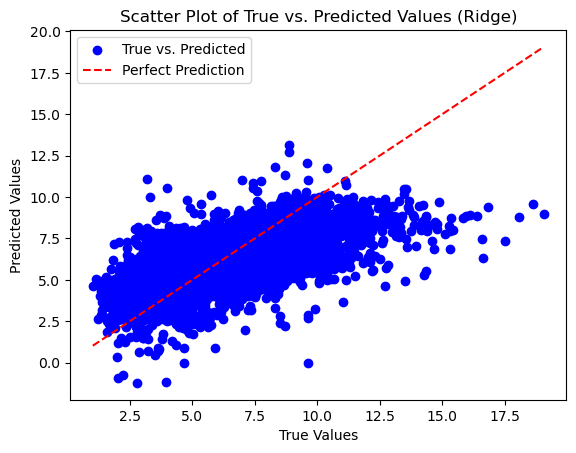

In [42]:
# 繪製散點圖
plt.scatter(y_test, y_pred, color='blue', label='True vs. Predicted')
plt.plot([min(np.array(y_test)), max(np.array(y_test))], [min(np.array(y_test)), max(np.array(y_test))], linestyle='--', color='red', label='Perfect Prediction')

# 
# 加上標題和軸標籤
plt.title('Scatter Plot of True vs. Predicted Values (Ridge)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# 加上圖例
plt.legend()

# 顯示圖形
plt.show()

In [43]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=10, random_state=0, alphas=[0.1, 1, 5, 10]).fit(X_train, y_train)

y_pred = lasso.predict(X_test)
score = lasso.score(X_test, y_test)
print("score: ", score)
test_result("Lasso", y_test, y_pred)
print("alpha", lasso.alpha_)

lasso_coef = pd.DataFrame(data=lasso.coef_ , index=total_label, columns=['coef'])
lasso_coef['abs_coef'] = abs(lasso_coef['coef'])
lasso_coef.sort_values(by=['abs_coef'], ascending=False)

score:  0.3815950819823035
------ model: Lasso --------
mse:  4.272030528162068
mae:  1.630038187708363
rmse:  2.06688909430624
MAPE:  0.3438756814572777
alpha 0.1


/Users/jim/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,coef,abs_coef
motor_torque(N-m),1.40669273465899169473,1.40669273465899169473
atmospheric_temperature(°C),-0.71709290784516743766,0.71709290784516743766
area_temperature(°C),0.55273730548228272585,0.55273730548228272585
engine_temperature(°C),0.21797029110712143329,0.21797029110712143329
wind_speed(m/s),-0.15718414974757011215,0.15718414974757011215
atmospheric_pressure(Pascal),0.07363413856046581440,0.07363413856046581440
blades_angle(°),-0.04878701139356712152,0.04878701139356712152
blade_breadth(m),0.04120131369125366178,0.04120131369125366178
wind_direction(°),-0.01784147216532053562,0.01784147216532053562
turbine_status_B2,-0.00000000000000000000,0.00000000000000000000


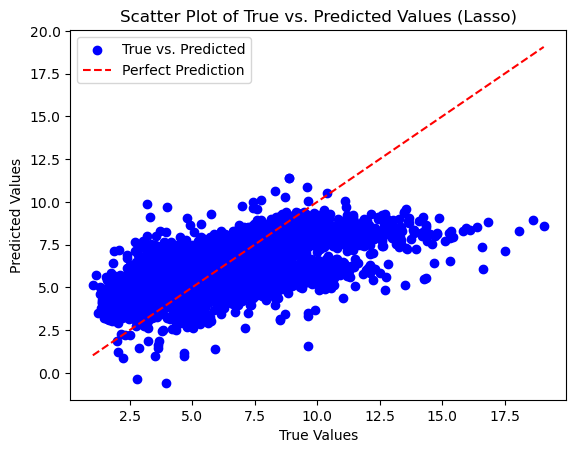

In [44]:
# 繪製散點圖
plt.scatter(y_test, y_pred, color='blue', label='True vs. Predicted')
plt.plot([min(np.array(y_test)), max(np.array(y_test))], [min(np.array(y_test)), max(np.array(y_test))], linestyle='--', color='red', label='Perfect Prediction')

# 
# 加上標題和軸標籤
plt.title('Scatter Plot of True vs. Predicted Values (Lasso)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# 加上圖例
plt.legend()

# 顯示圖形
plt.show()

In [45]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [2, 5, 8, 10]
    
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(neigh, param_grid, cv=10, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_accuracy = grid_search.best_score_
best_params = grid_search.best_params_

# Evaluate the model with the best hyperparameters on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
score = best_model.score(X_test, y_test)

print("score: ", score)
test_result("KNN", y_test, y_pred)

score:  0.5823849646307211
------ model: KNN --------
mse:  2.884945006317023
mae:  1.2956831684878247
rmse:  1.698512586446454
MAPE:  0.2656260838564035


In [46]:
best_params

{'n_neighbors': 10}

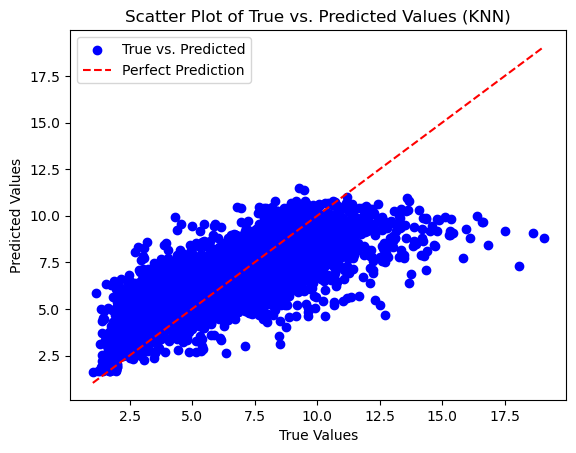

In [47]:
# 繪製散點圖
plt.scatter(y_test, y_pred, color='blue', label='True vs. Predicted')
plt.plot([min(np.array(y_test)), max(np.array(y_test))], [min(np.array(y_test)), max(np.array(y_test))], linestyle='--', color='red', label='Perfect Prediction')

# 
# 加上標題和軸標籤
plt.title('Scatter Plot of True vs. Predicted Values (KNN)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# 加上圖例
plt.legend()

# 顯示圖形
plt.show()

# 簡化欄位

## 只移掉最無用四個欄位

In [48]:
df_mice_dummy_drop = df_mice_dummy.drop(columns=['shaft_temperature(°C)', 'rotor_torque(N-m)', 'blade_length(m)', 'windmill_height(m)'])

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df_mice_dummy_drop, y, test_size=0.2, random_state=789)
numCols = [col for col in df_mice_dummy_drop.columns if df_mice_dummy_drop[col].dtype == 'float64']
xscaler = preprocessing.StandardScaler().fit(X_train[numCols])
#standardize feature values
X_train[numCols] = xscaler.transform(X_train[numCols])
X_test[numCols] = xscaler.transform(X_test[numCols])

In [50]:
import statsmodels.api as sm

x_model = sm.add_constant(X_train)
est = sm.OLS(np.array(y_train), x_model)
model = est.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     506.1
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        00:36:53   Log-Likelihood:                -44886.
No. Observations:               20788   AIC:                         8.983e+04
Df Residuals:                   20760   BIC:                         9.005e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [51]:
abs(model.tvalues).sort_values(ascending=False)

const                           124.16796275234170821022
motor_torque(N-m)                75.07044109829841715964
atmospheric_temperature(°C)      50.27043408488726328187
area_temperature(°C)             34.60799218499604990029
engine_temperature(°C)           19.19856726583195793978
wind_speed(m/s)                  17.10593792883292252327
atmospheric_pressure(Pascal)     11.44431659531924339035
blade_breadth(m)                  9.08953947406654449992
wind_direction(°)                 8.14945662589131103459
blades_angle(°)                   7.29555922810455204086
windmill_body_temperature(°C)     2.24847178231442512697
gearbox_temperature(°C)           1.50501179198237289292
turbine_status_B                  1.11586829229869199942
turbine_status_A2                 0.85285147101657687863
turbine_status_D                  0.72528156027251677873
turbine_status_AAA                0.70492759450968045520
resistance(ohm)                   0.55386895626397902870
turbine_status_BB              

In [52]:
import numpy as np
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
score = reg.score(X_test, y_test)

print("score: ", score)
print("mse: ", mean_squared_error(y_test, y_pred))
print("mae: ", mean_absolute_error(y_test, y_pred))
print("rmse: ", mean_squared_error(y_test, y_pred, squared=False))


coef = reg.coef_
linear_coef = pd.DataFrame(data=coef[0] , index=X_train.columns.tolist(), columns=['coef'])
linear_coef['abs_coef'] = abs(linear_coef['coef'])
linear_coef.sort_values(by=['abs_coef'], ascending=False)

score:  0.40982874592818785
mse:  4.352826467266619
mae:  1.6196743139611987
rmse:  2.086342845092009


,coef,abs_coef
motor_torque(N-m),1.58782242172241394584,1.58782242172241394584
atmospheric_temperature(°C),-0.96124028698527252956,0.96124028698527252956
area_temperature(°C),0.61271144616178452313,0.61271144616178452313
engine_temperature(°C),0.31289446268670689788,0.31289446268670689788
wind_speed(m/s),-0.27775550476261240407,0.27775550476261240407
atmospheric_pressure(Pascal),0.17174648783266810437,0.17174648783266810437
blade_breadth(m),0.13288621344640430544,0.13288621344640430544
wind_direction(°),-0.12863517417599371062,0.12863517417599371062
blades_angle(°),-0.10866933908592828206,0.10866933908592828206
turbine_status_B,0.08652429107127126984,0.08652429107127126984


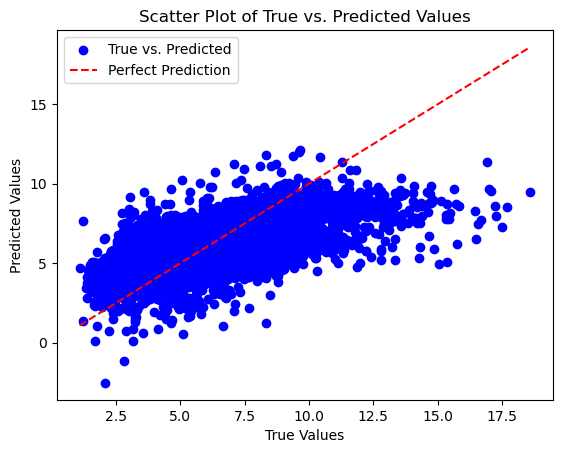

In [53]:
# 繪製散點圖
plt.scatter(y_test, y_pred, color='blue', label='True vs. Predicted')
plt.plot([min(np.array(y_test)), max(np.array(y_test))], [min(np.array(y_test)), max(np.array(y_test))], linestyle='--', color='red', label='Perfect Prediction')

# 
# 加上標題和軸標籤
plt.title('Scatter Plot of True vs. Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# 加上圖例
plt.legend()

# 顯示圖形
plt.show()

In [54]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=0, max_depth= 15, min_samples_leaf= 2, min_samples_split= 2)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)

print("score: ", score)
print("mse: ", mean_squared_error(y_test, y_pred))
print("mae: ", mean_absolute_error(y_test, y_pred))
print("rmse: ", mean_squared_error(y_test, y_pred, squared=False))


feature_importance = np.array(rf.feature_importances_)
rf_coef = pd.DataFrame(data=feature_importance , index=X_train.columns.tolist(), columns=['feature_importance'])
rf_coef.sort_values(by=['feature_importance'], ascending=False)

/var/folders/rh/7g0n3djn3wj8dlnjv7plmzcr0000gn/T/ipykernel_39204/3934890913.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


score:  0.9577159653771761
mse:  0.31186721443848936
mae:  0.3047210997338854
rmse:  0.5584507269567203


,feature_importance
motor_torque(N-m),0.60298550938011585831
blades_angle(°),0.21715893735761787608
atmospheric_pressure(Pascal),0.08282918652240092716
resistance(ohm),0.04953560086771631454
engine_temperature(°C),0.01417478509649427836
wind_speed(m/s),0.00800440027244499024
blade_breadth(m),0.00770343349431683658
area_temperature(°C),0.00463444972915842950
gearbox_temperature(°C),0.00371245513313889003
wind_direction(°),0.00330722534413534480


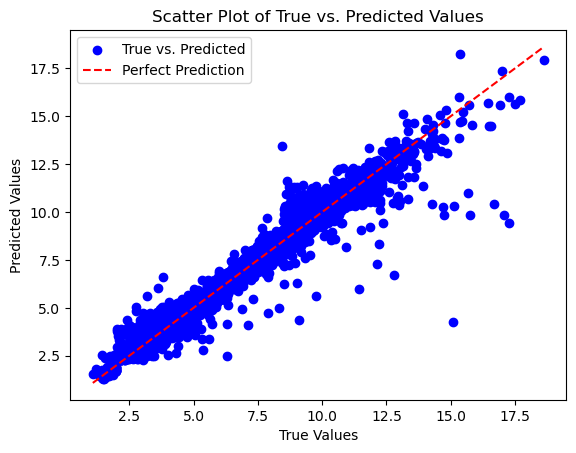

In [55]:
# 繪製散點圖
plt.scatter(y_test, y_pred, color='blue', label='True vs. Predicted')
plt.plot([min(np.array(y_test)), max(np.array(y_test))], [min(np.array(y_test)), max(np.array(y_test))], linestyle='--', color='red', label='Perfect Prediction')

# 
# 加上標題和軸標籤
plt.title('Scatter Plot of True vs. Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# 加上圖例
plt.legend()

# 顯示圖形
plt.show()

In [56]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(random_state=0, min_samples_leaf =  4, min_samples_split= 2)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
score = gb.score(X_test, y_test)
print("score: ", score)
print("mse: ", mean_squared_error(y_test, y_pred))
print("mae: ", mean_absolute_error(y_test, y_pred))
print("rmse: ", mean_squared_error(y_test, y_pred, squared=False))

feature_importance = np.array(gb.feature_importances_)
rank_of_coef = pd.DataFrame({'coef_name': X_train.columns.tolist(), 'feature_importance': feature_importance })
rank_of_coef.sort_values(by=['feature_importance'], ascending=False)


/Users/jim/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score:  0.9450412753088973
mse:  0.4053497858327451
mae:  0.40759225282285105
rmse:  0.6366708614604135


,coef_name,feature_importance
5,motor_torque(N-m),0.71000941113455351417
2,blades_angle(°),0.17853489689526572115
10,resistance(ohm),0.03144014657694201714
4,engine_temperature(°C),0.02874942979214627214
6,atmospheric_pressure(Pascal),0.02327289403057266129
0,wind_speed(m/s),0.01077580790247822419
11,blade_breadth(m),0.00742855121776478302
3,gearbox_temperature(°C),0.00710919703053818769
7,area_temperature(°C),0.00161386758536903878
9,wind_direction(°),0.00089152915409958981


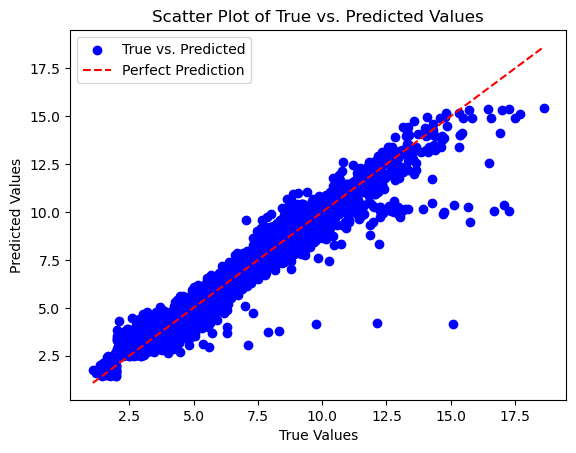

In [57]:
# 繪製散點圖
plt.scatter(y_test, y_pred, color='blue', label='True vs. Predicted')
plt.plot([min(np.array(y_test)), max(np.array(y_test))], [min(np.array(y_test)), max(np.array(y_test))], linestyle='--', color='red', label='Perfect Prediction')

# 
# 加上標題和軸標籤
plt.title('Scatter Plot of True vs. Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# 加上圖例
plt.legend()

# 顯示圖形
plt.show()

捨棄掉 'shaft_temperature(°C)', 'rotor_torque(N-m)', 'blade_length(m)', 'windmill_height(m)' 這幾個欄位之後 score 幾乎不變！可判斷這幾個欄位偏無用

## 只取最重要的欄位

In [64]:
df_mice_dummy_drop = df_mice_dummy.drop(columns=['shaft_temperature(°C)', 'rotor_torque(N-m)', 'blade_length(m)', 'windmill_height(m)', 'windmill_body_temperature(°C)', 'cloud_level_Low',  'cloud_level_Medium' ])

In [65]:
X_train, X_test, y_train, y_test = train_test_split(df_mice_dummy_drop, y, test_size=0.2, random_state=789)
numCols = [col for col in df_mice_dummy_drop.columns if df_mice_dummy_drop[col].dtype == 'float64']
X_train.to_json('../Model/trainDataDf.json', orient='records')
xscaler = preprocessing.StandardScaler().fit(X_train[numCols])
#standardize feature values
X_train[numCols] = xscaler.transform(X_train[numCols])
X_test[numCols] = xscaler.transform(X_test[numCols])

In [66]:
rf = RandomForestRegressor(random_state=0, max_depth= 15, min_samples_leaf= 2, min_samples_split= 2)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)

print("score: ", score)
print("mse: ", mean_squared_error(y_test, y_pred))
print("mae: ", mean_absolute_error(y_test, y_pred))
print("rmse: ", mean_squared_error(y_test, y_pred, squared=False))


feature_importance = np.array(rf.feature_importances_)
rf_coef = pd.DataFrame(data=feature_importance , index=X_train.columns.tolist(), columns=['feature_importance'])
rf_coef.sort_values(by=['feature_importance'], ascending=False)

/var/folders/rh/7g0n3djn3wj8dlnjv7plmzcr0000gn/T/ipykernel_39204/199425319.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


score:  0.9576559948189246
mse:  0.31230952915885674
mae:  0.304084305027202
rmse:  0.5588466061083817


,feature_importance
motor_torque(N-m),0.60333184421003971387
blades_angle(°),0.21731432858341312442
atmospheric_pressure(Pascal),0.08293397167048437157
resistance(ohm),0.04978091908626566808
engine_temperature(°C),0.01435763764276456675
wind_speed(m/s),0.00823929383088274798
blade_breadth(m),0.00781583974269721600
area_temperature(°C),0.00481348380000374155
gearbox_temperature(°C),0.00388365807007371670
wind_direction(°),0.00346426855264115197


In [62]:
gb = GradientBoostingRegressor(random_state=0, min_samples_leaf =  4, min_samples_split= 2)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
score = gb.score(X_test, y_test)
print("score: ", score)
print("mse: ", mean_squared_error(y_test, y_pred))
print("mae: ", mean_absolute_error(y_test, y_pred))
print("rmse: ", mean_squared_error(y_test, y_pred, squared=False))

feature_importance = np.array(gb.feature_importances_)
rank_of_coef = pd.DataFrame({'coef_name': X_train.columns.tolist(), 'feature_importance': feature_importance })
rank_of_coef.sort_values(by=['feature_importance'], ascending=False)


/Users/jim/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score:  0.9450426520214397
mse:  0.4053396318465056
mae:  0.40760380932761503
rmse:  0.636662887128271


,coef_name,feature_importance
5,motor_torque(N-m),0.71001236187117899856
2,blades_angle(°),0.17853422479377448195
9,resistance(ohm),0.03144175258422304137
4,engine_temperature(°C),0.02874902398918534677
6,atmospheric_pressure(Pascal),0.02327328294509781528
0,wind_speed(m/s),0.01077582561098852296
10,blade_breadth(m),0.00742863580230650709
3,gearbox_temperature(°C),0.00710917779924428138
7,area_temperature(°C),0.00161395595938464555
8,wind_direction(°),0.00089130735677736322


# export final random forest model

In [63]:
import pickle

filename = "../Model/final_random_forest.pickle"

# save model
pickle.dump(rf, open(filename, "wb"))